# Exploratory Data Analysis of HAR70+ Dataset
Dataset can be found [here](https://archive.ics.uci.edu/dataset/780/har70). (corresponding [paper](https://www.mdpi.com/1424-8220/23/5/2368))

**Table of Contents**
1. [Imports](#0-imports)

## Dataset Information 
(taken from link)
For what purpose was the dataset created?

The purpose was to train machine learning models for human activity recognition on professionally-annotated accelerometer data of fit-to-frail older adults.

Additional Information

The HAR70+ dataset contains recordings of 18 older adult participants wearing two 3-axial Axivity AX3 accelerometers for around 40 minutes in a semi-structured free-living setting. The participants' age was between 70 and 95 years. Five of the 18 subjects used walking aids during data recording. One sensor was attached to the right front thigh and the other to the lower back. The provided sampling rate is 50Hz. Video recordings of a chest-mounted camera were used to annotate the performed activities frame-by-frame.

Each subject's recordings are provided in a separate .csv file. One such .csv file contains the following columns:
1. timestamp: date and time of recorded sample
2. back_x: acceleration of back sensor in x-direction (down) in the unit g
3. back_y: acceleration of back sensor in y-direction (left) in the unit g
4. back_z: acceleration of back sensor in z-direction (forward) in the unit g
5. thigh_x: acceleration of thigh sensor in x-direction (down) in the unit g
6. thigh_y: acceleration of thigh sensor in y-direction (right) in the unit g
7. thigh_z: acceleration of thigh sensor in z-direction (backward) in the unit g
8. label: annotated activity code

The dataset contains the following annotated activities with the corresponding coding scheme:
1: walking	
3: shuffling
4: stairs (ascending)	
5: stairs (descending)	
6: standing	
7: sitting	
8: lying

## 1. Imports

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [ ]:
# Generic/Built-in
from typing import *

# Libs
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Custom
from data_preparation import *

In [6]:
train_dataset_norm, val_dataset_norm, test_dataset_norm, norm_stats = prepare_datasets()

Loading saved components...


In [7]:
train_dataset_norm[0]

(tensor([[-0.4634, -0.3081,  0.6457, -0.5353,  0.1555,  0.7497],
         [-0.4515, -0.4889,  0.6079, -0.5238,  0.1520,  0.7516],
         [-0.4397, -0.4404,  0.6028, -0.4991,  0.1894,  0.7321],
         [-0.3669, -0.3145,  0.5797, -0.5106,  0.2598,  0.6945],
         [-0.3396, -0.2322,  0.6074, -0.5238,  0.2866,  0.6803],
         [-0.3833, -0.2467,  0.5695, -0.5220,  0.2331,  0.7088],
         [-0.3233, -0.2403,  0.5763, -0.5220,  0.2224,  0.7231],
         [-0.3278, -0.2338,  0.5786, -0.5220,  0.1903,  0.6855],
         [-0.3497, -0.2726,  0.5650, -0.5220,  0.0691,  0.7331],
         [-0.4042, -0.3694,  0.5340, -0.5220,  0.0281,  0.7531],
         [-0.3751, -0.3097,  0.5396, -0.5220,  0.1404,  0.7298],
         [-0.2960, -0.2161,  0.5368, -0.5251,  0.1689,  0.6684],
         [-0.2860, -0.2806,  0.5470, -0.4947,  0.1172,  0.6289],
         [-0.3406, -0.3517,  0.6141, -0.5181,  0.0575,  0.6284],
         [-0.3378, -0.4114,  0.6446, -0.5198, -0.0013,  0.5960],
         [-0.3060, -0.375

In [ ]:
download_har70plus_dataset()

Download complete: data/har70.zip
Files extracted to: data directory


## 2. Examine Dataset
The dataset consists of 18 separate `csv` files (`501.csv` to `518.csv`), one for each subject.

In [4]:
# Load all 18 datasets and combine them into a single dataframe
df_ls = []
for subject_code in range(501, 519):
    file_path = f"data/har70plus/{subject_code}.csv" 
    df_ls.append(pd.read_csv(file_path))
    
df = pd.concat(df_ls, ignore_index=True)
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6


In [5]:
# Check for missing values
df.isnull().sum()

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64

In [6]:
# See sample labels
df["label"].value_counts().sort_index()
# There is no label 2

label
1    1079312
3      66058
4       4560
5       4978
6     418055
7     483452
8     203182
Name: count, dtype: int64

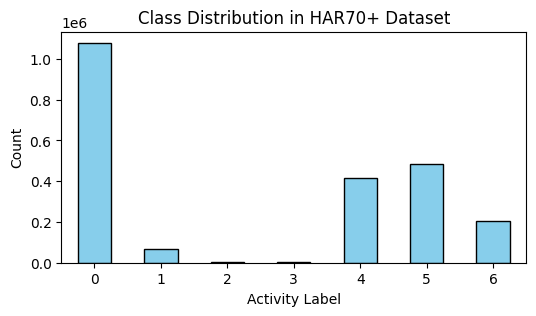

label
0    1079312
1      66058
2       4560
3       4978
4     418055
5     483452
6     203182
Name: count, dtype: int64

In [7]:
# Remap the labels
label_mapping = {1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
df["label"] = df["label"].map(label_mapping)
label_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(6, 3))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Activity Label")
plt.ylabel("Count")
plt.title("Class Distribution in HAR70+ Dataset")
plt.xticks(rotation=0)
plt.show()
label_counts


In [8]:
# Check timestamp format
df['timestamp'].head()

0    2021-03-24 14:42:03.839
1    2021-03-24 14:42:03.859
2    2021-03-24 14:42:03.880
3    2021-03-24 14:42:03.900
4    2021-03-24 14:42:03.920
Name: timestamp, dtype: object

- dataset has average time interval of 0.020 seconds (20 milliseconds) between consecutive samples, which aligns with the 50HZ sampling rate (1/50 = 0.02 seconds). However, there are occasionally larger gaps (up to 4.86 seconds), which might be due to pauses in recording or data. 
- fixed size sequences: sliding window
- many to one model

In [9]:
# Convert timestamp to datetime and calculate time differences
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_diff'] = df['timestamp'].diff().dt.total_seconds()

# Summary statistics of timestamp gaps
print(df['timestamp_diff'].describe())

# Identify breakpoints (where gaps are larger than expected 0.02s)
gap_threshold = 0.05  # Slightly higher than 0.02 to account for minor variations
breakpoints = df[df['timestamp_diff'] > gap_threshold].index

# Print breakpoints
print(f"Identified {len(breakpoints)} breakpoints at indices:", breakpoints.tolist())

count    2.259596e+06
mean     3.015172e+00
std      1.472069e+03
min      1.900000e-02
25%      2.000000e-02
50%      2.000000e-02
75%      2.000000e-02
max      1.190987e+06
Name: timestamp_diff, dtype: float64
Identified 272 breakpoints at indices: [4776, 11606, 16496, 23448, 23580, 26206, 26866, 29194, 97844, 103248, 103860, 105414, 105480, 111954, 112648, 118506, 130718, 130850, 131222, 139382, 230814, 230960, 233248, 235227, 238113, 242565, 244533, 247949, 249601, 265215, 267421, 267425, 275505, 277267, 277873, 278419, 294777, 297701, 351640, 352794, 365228, 366342, 366362, 372392, 376730, 385150, 395558, 403762, 406144, 406314, 406510, 409374, 414008, 495858, 498600, 502398, 506630, 524122, 526558, 539938, 540012, 543636, 556296, 589404, 590788, 590904, 607084, 609392, 609456, 620686, 621110, 629544, 636848, 639070, 641590, 642546, 644420, 644536, 645070, 645310, 645334, 704400, 712118, 713301, 714293, 714589, 723229, 725711, 728223, 729567, 731187, 736459, 736717, 743999, 74987

In [10]:
df["timestamp"].iloc[6350: 6360]

6350   2021-03-24 14:44:12.000
6351   2021-03-24 14:44:12.020
6352   2021-03-24 14:44:12.039
6353   2021-03-24 14:44:12.059
6354   2021-03-24 14:44:12.079
6355   2021-03-24 14:44:12.100
6356   2021-03-24 14:44:12.119
6357   2021-03-24 14:44:12.140
6358   2021-03-24 14:44:12.159
6359   2021-03-24 14:44:12.180
Name: timestamp, dtype: datetime64[ns]

## 3. Dataset Preparation

In [11]:
# Create dataset
dataset = HARDataset(df, sequence_size=100, stride=50)
len(dataset)

44796

In [13]:
train_dataset_norm, val_dataset_norm, test_dataset_norm, norm_stats = split_dataset(dataset)

In [17]:
train_dataset_norm[5]

(tensor([[-0.4252, -0.3000, -0.8204, -0.5220, -0.5861,  0.6912],
         [-0.4315, -0.3000, -0.8131, -0.5220, -0.6306,  0.6803],
         [-0.3751, -0.3000, -0.8142, -0.5220, -0.5861,  0.6531],
         [-0.3660, -0.2887, -0.8142, -0.5220, -0.6458,  0.6470],
         [-0.3669, -0.3904, -0.8142, -0.5220, -0.6377,  0.6298],
         [-0.3615, -0.4033, -0.8142, -0.5220, -0.6342,  0.6627],
         [-0.4197, -0.4033, -0.8142, -0.5220, -0.6556,  0.6489],
         [-0.4288, -0.4033, -0.8142, -0.5220, -0.7028,  0.6089],
         [-0.3697, -0.4033, -0.8142, -0.5220, -0.6993,  0.6017],
         [-0.3642, -0.4033, -0.8154, -0.5220, -0.6779,  0.6274],
         [-0.4233, -0.4033, -0.7781, -0.5220, -0.6012,  0.6408],
         [-0.4252, -0.4033, -0.8137, -0.5220, -0.5843,  0.6479],
         [-0.4243, -0.4017, -0.8142, -0.5220, -0.7144,  0.6217],
         [-0.3669, -0.2984, -0.8498, -0.5220, -0.6877,  0.6255],
         [-0.4261, -0.3016, -0.8131, -0.5220, -0.5513,  0.6255],
         [-0.4252, -0.401

In [28]:
import os
norm_stats_path = os.path.join("model", 'datas.pt')
torch.save(dataset, norm_stats_path)

In [25]:
d = torch.load(norm_stats_path, weights_only=False)

In [29]:
d.df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,timestamp_diff
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,4,NaN
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,4,0.020
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,4,0.021
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,4,0.020
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,4,0.020
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,0,0.019
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,0,0.020
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,0,0.020
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,0,0.021
